In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(legacy='1.25')

### Load the lattice

In [3]:
env = xt.Environment()
env.call('../fccee_z_lattice.py')

### Load quadrupole and sextupole strengths matched so far

In [4]:
env.vars.load_json('strengths_quads_00_arc_cell.json')
env.vars.load_json('strengths_quads_01_ffccsyl.json')
env.vars.load_json('strengths_quads_02_ffccsxl.json')
env.vars.load_json('strengths_quads_03_ffccsyr.json')
env.vars.load_json('strengths_quads_04_ffccsxr.json')
env.vars.load_json('strengths_quads_05_ffds_lr.json')
env.vars.load_json('strengths_quads_06_straight.json')

env.vars.load_json('strengths_sext_00_arc_cell.json')

### Select machine portion
(two half arcs adjacent to the experimental insertion)

In [5]:
line = env['fccee_p_ring']
section = line.select('mid_cell_edge_r::1','mid_cell_edge_l::2')

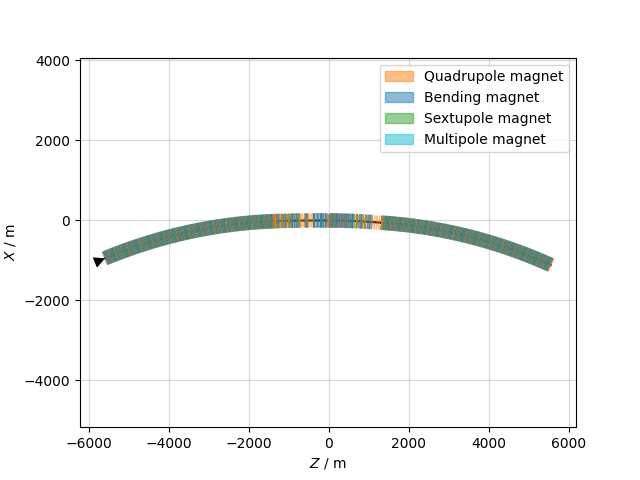

In [6]:
section.survey(element0='ip_mid').plot()

### Twiss arc mid cells to get boundary conditions

In [7]:
cell1 = line.select('mid_cell_edge_l::1','mid_cell_edge_r::1')
cell2 = line.select('mid_cell_edge_l::2','mid_cell_edge_r::2')

tw_cell_1 = cell1.twiss4d()
twinit_cell_1_r = tw_cell_1.get_twiss_init('mid_cell_edge_r')
tw_cell_2 = cell2.twiss4d()
twinit_cell_2_l = tw_cell_1.get_twiss_init('mid_cell_edge_l')

### Twiss full section with boundary conditions

In [8]:
tw0 = section.twiss(init=twinit_cell_1_r,
                    compute_chromatic_properties=True)

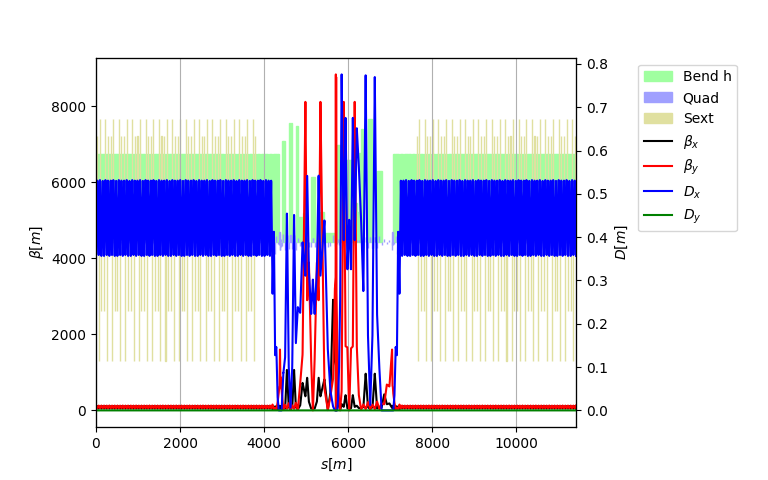

In [9]:
pp = tw0.plot()

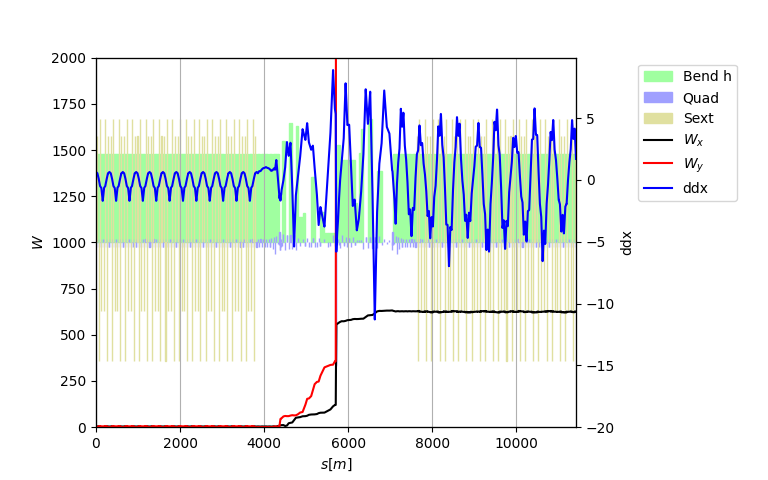

In [10]:
# W functions and second order dispersion before match
pp = tw0.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_lo=0, left_hi=2000, right_lo=-20)

### Use sextupoles in the Chromatic correction sections to control W functions at IP

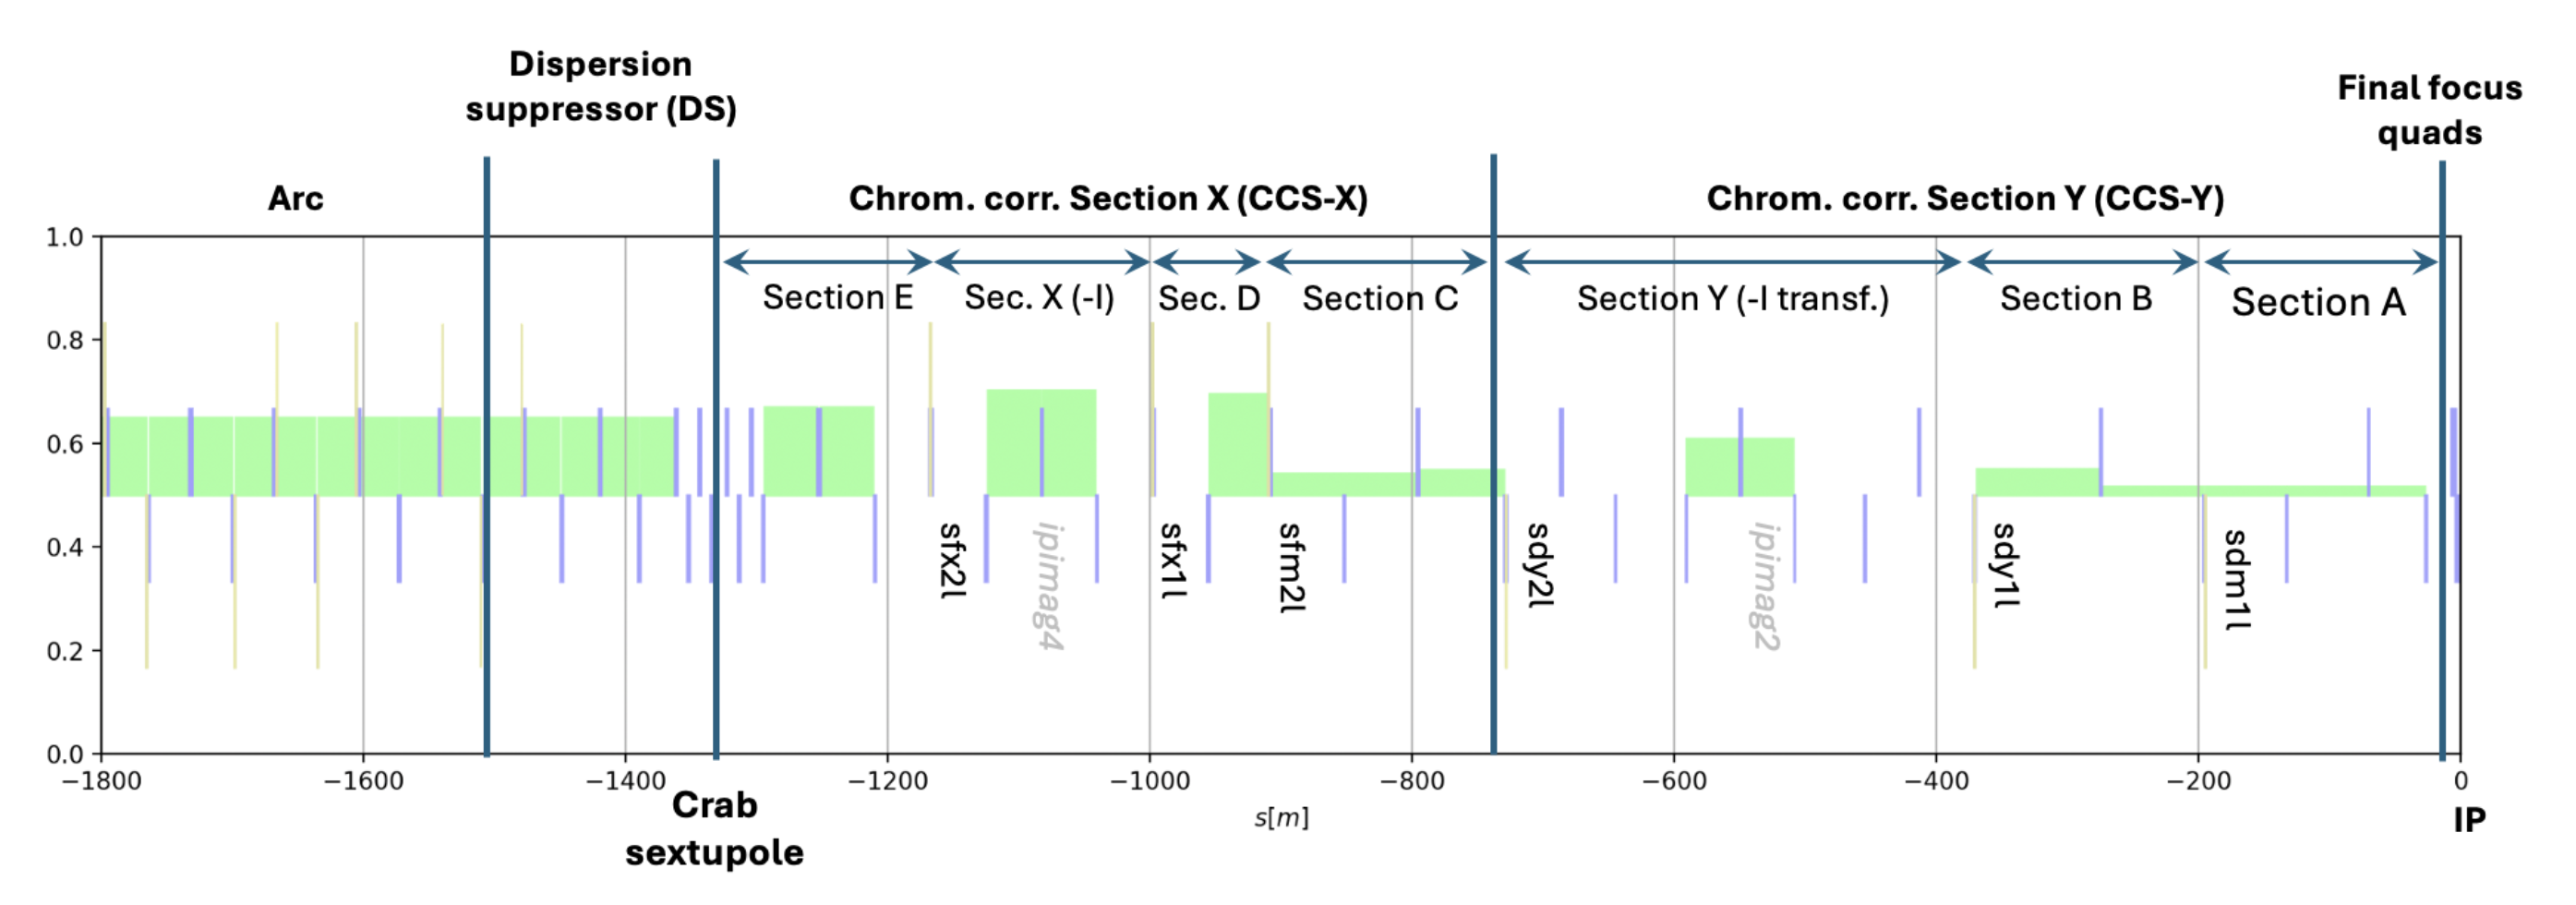

In [19]:
opt_w_left = section.match(
    name='w_left',
    solve=False,
    init=twinit_cell_1_r,
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksfx1l', 'ksdy1l'], step=1e-3),
    targets=xt.TargetSet(wx_chrom=0, wy_chrom=0, at='ip_mid')
)
opt = opt_w_left
opt.step(10)

opt_w_right = section.match(
    name='w_right',
    solve=False,
    init=twinit_cell_2_l,
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksfx1r', 'ksdy1r'], step=1e-3),
    targets=xt.TargetSet(wx_chrom=0, wy_chrom=0, at='ip_mid')
)
opt = opt_w_right
opt.step(10)

                                             
Optimize [w_left] - start penalty: 15.27                         
Matching: model call n. 73 penalty = 1.1563e+01              
Optimize [w_left] - end penalty:  11.5633                            
                                             
Optimize [w_right] - start penalty: 13.97                         
Matching: model call n. 62 penalty = 8.0028e+00              
Optimize [w_right] - end penalty:  8.00281                            


### Match chromatic functions to those of the arcs

In [20]:
opt_close_w = section.match(
    name='close',
    solve=False,
    init=twinit_cell_1_r, # <-- start arc boundary conditions on the left
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksfx1l', 'ksdy1l', 'ksfx1r', 'ksdy1r'], step=1e-3),
    targets=[xt.TargetSet(ax_chrom=twinit_cell_1_r.ax_chrom,
                         ay_chrom=twinit_cell_1_r.ay_chrom,
                         bx_chrom=twinit_cell_1_r.bx_chrom,
                         by_chrom=twinit_cell_1_r.by_chrom,
                         at=xt.END), # <-- match to arc boundary conditions on the left
            xt.TargetSet(wx_chrom=xt.LessThan(10), wy_chrom=xt.LessThan(10),
                         at='ip_mid')]
)
opt = opt_close_w
opt.step(10)

                                             
Optimize [close] - start penalty: 6.679                         
Matching: model call n. 80 penalty = 3.9329e+00              
Optimize [close] - end penalty:  3.93291                            


### Inspect
W functions are matched, second-order dispersion is still mismatched

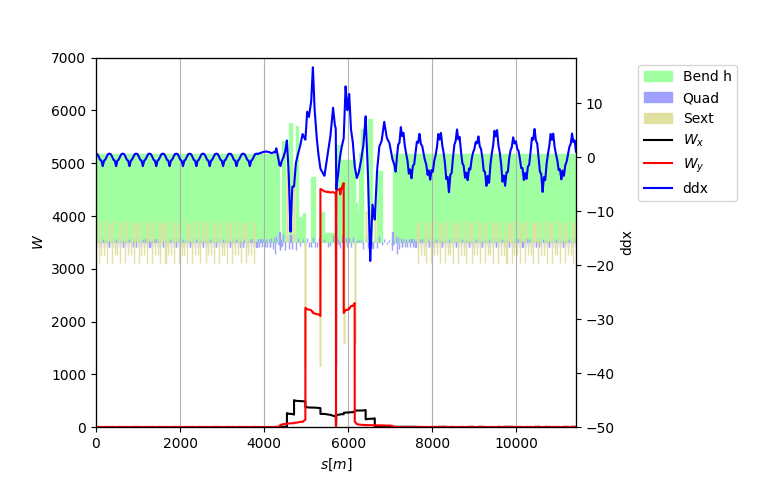

In [21]:
pp = opt.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_lo=0, left_hi=7000, right_lo=-50)

### Correction of high-order chromaticity

In [22]:
# Made a little module to fit dependence on delta of local optics properties
import sys
sys.path.append('../002_design_optics/')
from local_nl_chromaticity import LocalNonLinearChromaticity

In [23]:
act = LocalNonLinearChromaticity(section=section)

In [24]:
nlchr_0 = act.run()

In [25]:
nlchr_0.keys()

dict_keys(['mux_l_test', 'muy_l_test', 'mux_r_test', 'muy_r_test', 'tw_test', 'delta_test', 'p_mux', 'p_muy', 'tt_0', 'mux_rms_l', 'muy_rms_l', 'mux_rms_r', 'muy_rms_r', 'mux_l_poly', 'muy_l_poly', 'mux_r_poly', 'muy_r_poly', 'dmux_l', 'd2mux_l', 'd3mux_l', 'd4mux_l', 'd5mux_l', 'dmuy_l', 'd2muy_l', 'd3muy_l', 'd4muy_l', 'd5muy_l', 'dmux_r', 'd2mux_r', 'd3mux_r', 'd4mux_r', 'd5mux_r', 'dmuy_r', 'd2muy_r', 'd3muy_r', 'd4muy_r', 'd5muy_r'])

Text(0, 0.5, '($\\Delta\\mu_x)_\\text{IR-LEFT}$')

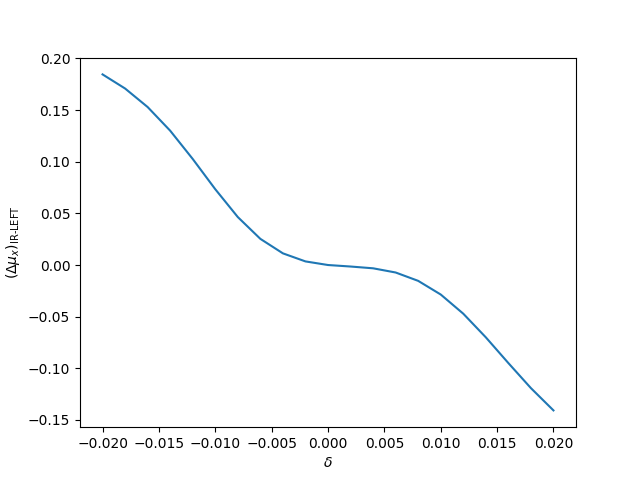

In [26]:
plt.figure()
plt.plot(nlchr_0['delta_test'], nlchr_0['mux_r_test'])
plt.xlabel(r'$\delta$')
plt.ylabel(r'($\Delta\mu_x)_\text{IR-LEFT}$')

### Use additional IR sextupole to match 3rd order chromaticity

In [27]:
opt_chrom3_y_left = section.match(
    name='chrom3_l_y',
    solve=False,
    vary=xt.VaryList(['ksdm1l'], step=1e-3, limits=[-0.5, 0.5]),
    targets=[
        act.target('dmuy_l', xt.LessThan(0.1), tol=0.01, weight=1e4, tag='dmuy_l'),
        act.target('dmuy_l', xt.GreaterThan(-0.1), tol=0.01, weight=1e4, tag='dmux_l'),
        act.target('d3muy_l', xt.LessThan(1e3), tol=1, weight=1, tag='d3muy_l'),
        act.target('d3muy_l', xt.GreaterThan(-1e3), tol=1, weight=1, tag='d3muy_l'),
        act.target('muy_rms_l', xt.LessThan(0.05), tol=0.1, weight=1e6, tag='muy_rms_l'),
    ]
)
opt = opt_chrom3_y_left
opt.run_direct(20)

                                             
Optimize [chrom3_l_y] - start penalty: 2.115e+05                         
Matching: model call n. 24 penalty = 8.4560e+03              
Optimize [chrom3_l_y] - end penalty:  8456.02                            


In [28]:
opt_chrom3_x_left = section.match(
    name='chrom3_l_x',
    solve=False,
    vary=xt.VaryList(['ksfm2l'], step=1e-3, limits=[-0.5, 0.5]),
    targets=[
        act.target('dmux_l', xt.LessThan(0.1), tol=0.01, weight=1e4, tag='dmux_l'),
        act.target('dmux_l', xt.GreaterThan(-0.1), tol=0.01, weight=1e4, tag='dmux_l'),
        act.target('d3mux_l', xt.LessThan(1e3), tol=1, weight=1, tag='d3mux_l'),
        act.target('d3mux_l', xt.GreaterThan(-1e3), tol=1, weight=1, tag='d3mux_l'),
        act.target('mux_rms_l', xt.LessThan(0.05), tol=0.1, weight=1e6, tag='mux_rms_l'),
    ]
)
opt = opt_chrom3_x_left
opt.run_direct(20)

                                             
Optimize [chrom3_l_x] - start penalty: 3.435e+05                         
Matching: model call n. 24 penalty = 3.4083e+04              
Optimize [chrom3_l_x] - end penalty:  34083                            


In [29]:
opt_chrom3_y_right = section.match(
    name='chrom3_r_y',
    solve=False,
    vary=xt.VaryList(['ksdm1r'], step=1e-3, limits=[-0.5, 0.5]),
    targets=[
        act.target('dmuy_r', xt.LessThan(1), tol=0.01, weight=1e4, tag='dmuy_r'),
        act.target('dmuy_r', xt.GreaterThan(-1), tol=0.01, weight=1e4, tag='dmuy_r'),
        act.target('d3muy_r', xt.LessThan(3e3), tol=1, weight=1, tag='d3muy_r'),     # For some reason this givea a better behaviour in the closed twiss
        act.target('d3muy_r', xt.GreaterThan(-3e3), tol=1, weight=1, tag='d3muy_r'), # Allowing to go to delta 1.5e-2
        act.target('muy_rms_r', xt.LessThan(0.05), tol=0.1, weight=1e6, tag='muy_rms_r'),
    ]
)
opt = opt_chrom3_y_right
opt.run_direct(20)

                                             
Optimize [chrom3_r_y] - start penalty: 1.929e+05                         
Matching: model call n. 24 penalty = 7.8088e+03              
Optimize [chrom3_r_y] - end penalty:  7808.81                            


In [30]:
opt_chrom3_x_right = section.match(
    name='chrom3_r_x',
    solve=False,
    vary=xt.VaryList(['ksfm2r'], step=1e-3, limits=[-0.5, 0.5]),
    targets=[
        act.target('dmux_r', xt.LessThan(0.1), tol=0.01, weight=1e4, tag='dmux_r'),
        act.target('dmux_r', xt.GreaterThan(-0.1), tol=0.01, weight=1e4, tag='dmux_r'),
        act.target('d3mux_r', xt.LessThan(1e3), tol=1, weight=1, tag='d3mux_r'),
        act.target('d3mux_r', xt.GreaterThan(-1e3), tol=1, weight=1, tag='d3mux_r'),
        act.target('mux_rms_r', xt.LessThan(0.05), tol=0.1, weight=1e6, tag='mux_rms_r'),
    ]
)
opt = opt_chrom3_x_right
opt.run_direct(20)

                                             
Optimize [chrom3_r_x] - start penalty: 3.088e+05                         
Matching: model call n. 24 penalty = 7.8134e+03              
Optimize [chrom3_r_x] - end penalty:  7813.37                            


### Match second order dispersion

In [41]:
# Define additional sextupole circuits in cells adjacent to to the insertion
vars_ds_sextupoles = {}
vars_ds_sextupoles['ksf2al3'] = 'ksffam2 + ksf2al3_delta'
vars_ds_sextupoles['ksd1al3'] = 'ksdfam1'
vars_ds_sextupoles['ksf1al3'] = 'ksffam1 + ksf1al3_delta'
vars_ds_sextupoles['ksd2al3'] = 'ksdfam2'
vars_ds_sextupoles['ksd2bl3'] = 'ksdfam2'
vars_ds_sextupoles['ksf1bl3'] = 'ksffam1 + ksf1bl3_delta'
vars_ds_sextupoles['ksd1bl3'] = 'ksdfam1'
vars_ds_sextupoles['ksf2bl3'] = 'ksffam2 + ksf2bl3_delta'
vars_ds_sextupoles['ksf2fl']  = 'ksffam2 + ksf2fl_delta'
vars_ds_sextupoles['ksd1fl']  = 'ksdfam1'
vars_ds_sextupoles['ksf1fl']  = 'ksffam1 + ksf1fl_delta'
vars_ds_sextupoles['ksd2fl']  = 0
vars_ds_sextupoles['ksf3fl']  = 0
vars_ds_sextupoles['ksf3fr']  = 0
vars_ds_sextupoles['ksd2fr']  = 0
vars_ds_sextupoles['ksf1fr']  = 'ksffam1 + ksf1fr_delta'
vars_ds_sextupoles['ksd1fr']  = 'ksdfam1'
vars_ds_sextupoles['ksf2fr']  = 'ksffam2 + ksf2fr_delta'
vars_ds_sextupoles['ksf2br3'] = 'ksffam2 + ksf2br3_delta'
vars_ds_sextupoles['ksd1br3'] = 'ksdfam1'
vars_ds_sextupoles['ksf1br3'] = 'ksffam1 + ksf1br3_delta'
vars_ds_sextupoles['ksd2br3'] = 'ksdfam2'
vars_ds_sextupoles['ksd2ar3'] = 'ksdfam2'
vars_ds_sextupoles['ksf1ar3'] = 'ksffam1 + ksf1ar3_delta'
vars_ds_sextupoles['ksd1ar3'] = 'ksdfam1'
vars_ds_sextupoles['ksf2ar3'] = 'ksffam2 + ksf2ar3_delta'
env.vars.default_to_zero = True
env.vars.update(vars_ds_sextupoles)
env.vars.default_to_zero = True

ddx_left_knobs = ['ksf2al3_delta', 'ksf1al3_delta', 'ksf1bl3_delta',
                  'ksf2bl3_delta', 'ksf2fl_delta', 'ksf1fl_delta']
ddx_right_knobs = ['ksf1fr_delta', 'ksf2fr_delta', 'ksf2br3_delta',
                   'ksf1br3_delta', 'ksf1ar3_delta', 'ksf2ar3_delta']


In [42]:
# Match ddx and ddx to zero at the IP
opt_ddx_left = section.match(
    name='ddx_left',
    solve=False,
    init=twinit_cell_1_r,
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksf2al3_delta', 'ksf1al3_delta', 'ksf1bl3_delta',
                      'ksf2bl3_delta', 'ksf2fl_delta', 'ksf1fl_delta'], step=1e-4),
    targets=xt.TargetSet(ddx=0, ddpx=-0, at='ip_mid')
)
opt = opt_ddx_left
opt.step(5)


opt_ddx_right = section.match(
    name='ddx_right',
    solve=False,
    init=twinit_cell_2_l,
    compute_chromatic_properties=True,
    vary=xt.VaryList(['ksf1fr_delta', 'ksf2fr_delta', 'ksf2br3_delta',
                     'ksf1br3_delta', 'ksf1ar3_delta', 'ksf2ar3_delta'], step=1e-4),
    targets=[
        xt.TargetSet(ddx=0, ddpx=0, at='ip_mid'),
    ]
)
opt = opt_ddx_right
opt.step(5)


                                             
Optimize [ddx_left] - start penalty: 5.992e-12                         
Matching: model call n. 2 penalty = 5.9921e-12              
Optimize [ddx_left] - end penalty:  5.99212e-12                            
                                             
Optimize [ddx_right] - start penalty: 6.681e-06                         
Matching: model call n. 9 penalty = 3.2698e-10              
Optimize [ddx_right] - end penalty:  3.26979e-10                            


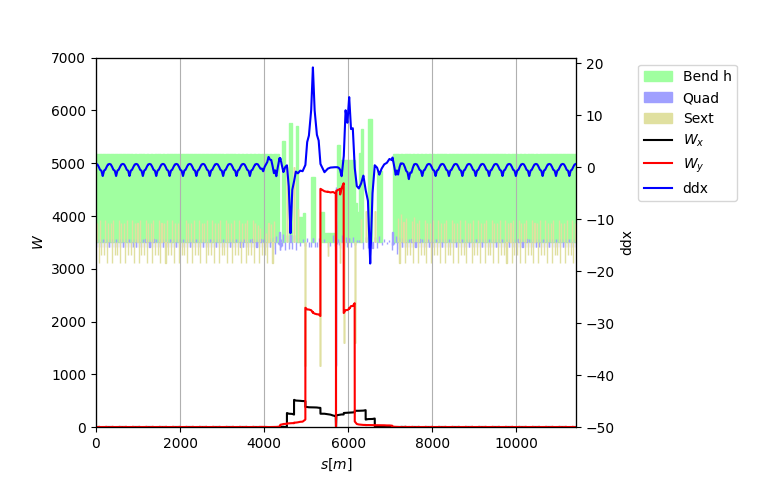

In [43]:
pp = opt_close_w.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_lo=0, left_hi=7000, right_lo=-50)

### Match Ws and second order dispersions together

In [44]:
opt = opt_close_w.clone(name='close_final').step(5)

opt_close_w_and_ddx = opt_close_w.clone(name='close_w_and_ddx',
                    remove_vary=True,
                    add_vary=list(opt_ddx_left.vary) + list(opt_ddx_right.vary),
                    add_targets=[
                    xt.TargetSet(
                        ddx=0, ddpx=0, at='ip_mid'),
                    xt.TargetSet(
                         ddx=twinit_cell_1_r.ddx,
                         ddpx=twinit_cell_1_r.ddpx,
                         at=xt.END),
                    ])
opt = opt_close_w_and_ddx
opt.step(5)

                                             
Optimize [close_final] - start penalty: 1.25e-05                         
Matching: model call n. 51 penalty = 1.0921e-05              
Optimize [close_final] - end penalty:  1.09214e-05                            
                                             
Optimize [close_w_and_ddx] - start penalty: 1.137e-05                         
Matching: model call n. 71 penalty = 1.0978e-08              
Optimize [close_w_and_ddx] - end penalty:  1.09781e-08                            


### Inspect

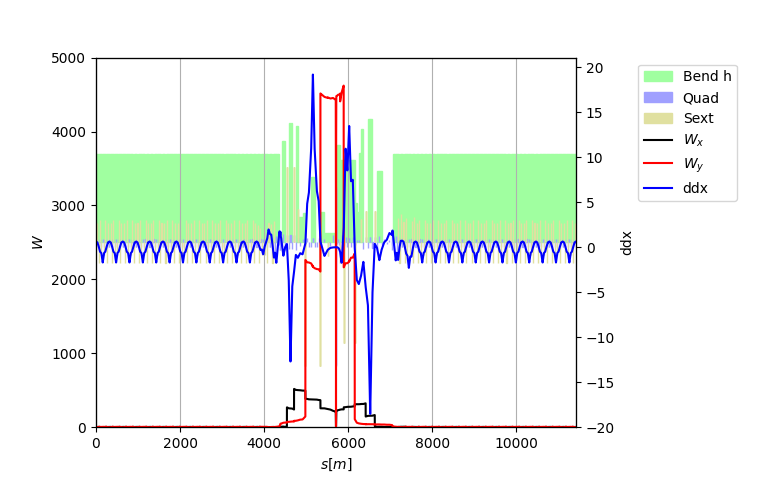

In [45]:
pp = opt.plot(yl='wx_chrom wy_chrom', yr='ddx')
pp.ylim(left_lo=0, left_hi=5000, right_lo=-20)

### Final non-linear chromaticity

In [46]:
nlchr_2 = act.run()

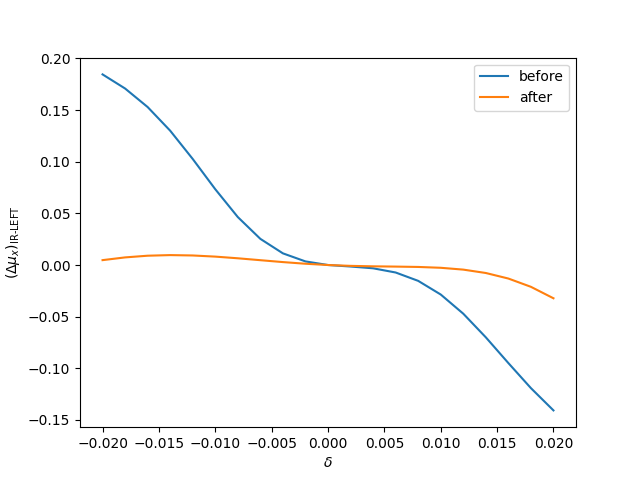

In [47]:
plt.figure()
plt.plot(nlchr_0['delta_test'], nlchr_0['mux_r_test'], label='before')
plt.plot(nlchr_2['delta_test'], nlchr_2['mux_r_test'], label='after')
plt.xlabel(r'$\delta$')
plt.ylabel(r'($\Delta\mu_x)_\text{IR-LEFT}$')
plt.legend()

### Save to file

In [48]:
vars_to_save = [
    'ksf2al3', 'ksd1al3', 'ksf1al3', 'ksd2al3', 'ksd2bl3', 'ksf1bl3', 'ksd1bl3', 'ksf2bl3',
    'ksf2fl', 'ksd1fl', 'ksf1fl', 'ksd2fl', 'ksf3fl', 'ksf3fr', 'ksd2fr', 'ksf1fr', 'ksd1fr',
    'ksf2fr', 'ksf2br3', 'ksd1br3', 'ksf1br3', 'ksd2br3', 'ksd2ar3', 'ksf1ar3', 'ksd1ar3',
    'ksf2ar3', 'ksfx1l', 'ksdy1l', 'ksfx1r', 'ksdy1r', 'ksfm2l', 'ksdm1l', 'ksfm2r', 'ksdm1r',
    'ksf2al3_delta', 'ksf1al3_delta', 'ksf1bl3_delta', 'ksf2bl3_delta', 'ksf2fl_delta',
    'ksf1fl_delta', 'ksf1fr_delta', 'ksf2fr_delta', 'ksf2br3_delta', 'ksf1br3_delta',
    'ksf1ar3_delta', 'ksf2ar3_delta'
]

In [49]:
out = line.vars.get_table().rows[vars_to_save].to_dict()

In [50]:
xt.json.dump(out, 'strengths_sext_02_final_focus.json')